In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
ls

cnn_lstm_model.keras             lstm_baseline.keras
final_gru_model.keras            lstm_improved.keras
final_model_comparison.csv       model_comparison_results.csv
final_transformer_model.keras    sample_data/
household_power_consumption.txt  scaler.pkl
household_power_hourly.csv       transformer_model.keras


In [105]:
df = pd.read_csv("household_power_consumption.txt", sep=';', parse_dates=[['Date','Time']], dayfirst=True, na_values=['?'], low_memory=False)

/tmp/ipython-input-1040140405.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv("household_power_consumption.txt", sep=';', parse_dates=[['Date','Time']], dayfirst=True, na_values=['?'], low_memory=False)


In [106]:
# STEP 1 — Dataset Understanding + EDA

In [107]:
df.rename(columns={'Date_Time':'datetime'}, inplace=True)

In [108]:
df.set_index('datetime', inplace=True)

In [109]:
# convert numeric columns reliably
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

In [110]:
print("shape:", df.shape)
print("date range:", df.index.min(), "to", df.index.max())
display(df.head())

shape: (2075259, 7)
date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [111]:
# missing counts & percent
miss = df.isna().sum().sort_values(ascending=False)
miss_pct = (miss / len(df) * 100).round(3)
missing_summary = pd.concat([miss, miss_pct], axis=1)
missing_summary.columns = ['missing_count','missing_percent']
display(missing_summary)

,missing_count,missing_percent
Global_active_power,25979,1.252
Global_reactive_power,25979,1.252
Voltage,25979,1.252
Global_intensity,25979,1.252
Sub_metering_1,25979,1.252
Sub_metering_2,25979,1.252
Sub_metering_3,25979,1.252


In [112]:
# dtypes
display(df.dtypes)

,0
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


In [113]:
display(df.describe().T.round(6))

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122
Global_reactive_power,2049280.0,0.123714,0.112722,0.000,0.048,0.100,0.194,1.390
Voltage,2049280.0,240.839858,3.239987,223.200,238.990,241.010,242.890,254.150
Global_intensity,2049280.0,4.627759,4.444396,0.200,1.400,2.600,6.400,48.400
Sub_metering_1,2049280.0,1.121923,6.153031,0.000,0.000,0.000,0.000,88.000
Sub_metering_2,2049280.0,1.298520,5.822026,0.000,0.000,0.000,1.000,80.000
Sub_metering_3,2049280.0,6.458447,8.437154,0.000,0.000,1.000,17.000,31.000


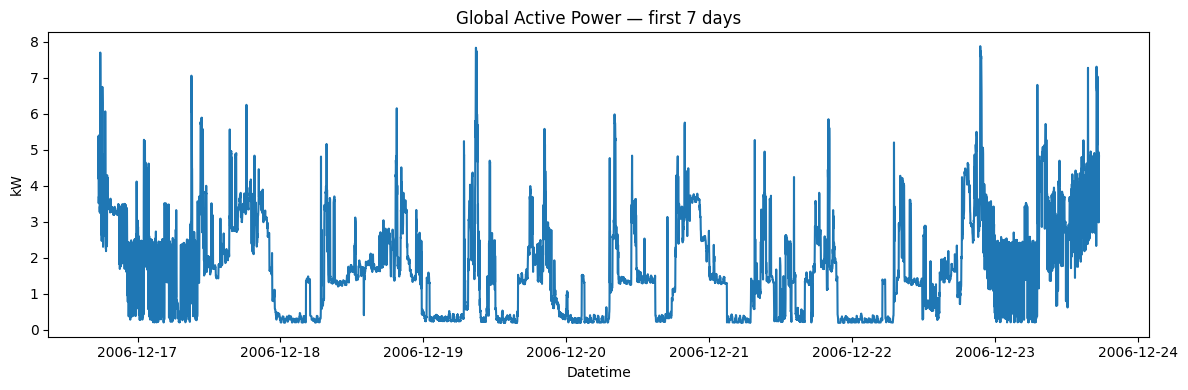

In [114]:
import matplotlib.pyplot as plt

# 7-day sample from start
start = df.index.min()
sample = df['Global_active_power'].loc[start:start + pd.Timedelta(days=7)]
plt.figure(figsize=(12,4))
plt.plot(sample.index, sample.values)
plt.title("Global Active Power — first 7 days")
plt.xlabel("Datetime"); plt.ylabel("kW")
plt.tight_layout()
plt.show()

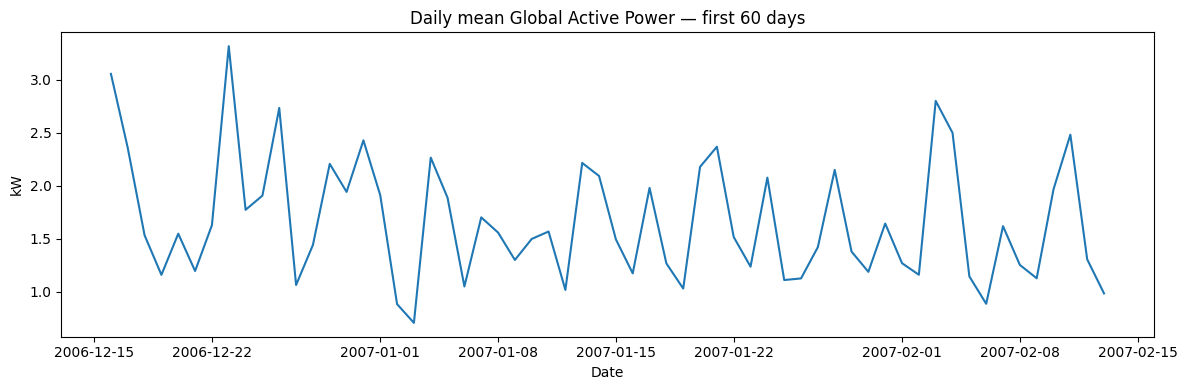

In [115]:
# daily mean (first 60 days)
daily = df['Global_active_power'].resample('D').mean()
plt.figure(figsize=(12,4))
plt.plot(daily.index[:60], daily.values[:60])
plt.title("Daily mean Global Active Power — first 60 days")
plt.xlabel("Date"); plt.ylabel("kW")
plt.tight_layout()
plt.show()

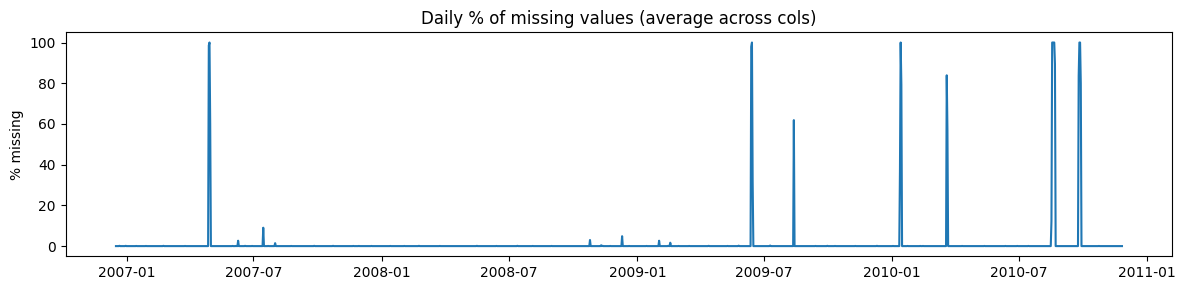

In [116]:
# percent missing per day
daily_missing_pct = df.isna().resample('D').mean().mean(axis=1) * 100
plt.figure(figsize=(12,3))
plt.plot(daily_missing_pct.index, daily_missing_pct.values)
plt.title("Daily % of missing values (average across cols)")
plt.ylabel("% missing"); plt.tight_layout(); plt.show()

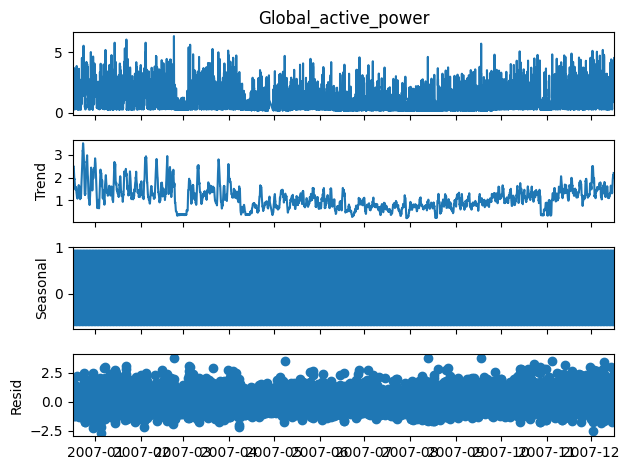

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

series = df['Global_active_power'].resample('h').mean().interpolate()  # hourly series, interpolated
res = seasonal_decompose(series.iloc[:24*365], model='additive', period=24)  # use one year or available
res.plot(); plt.tight_layout(); plt.show()

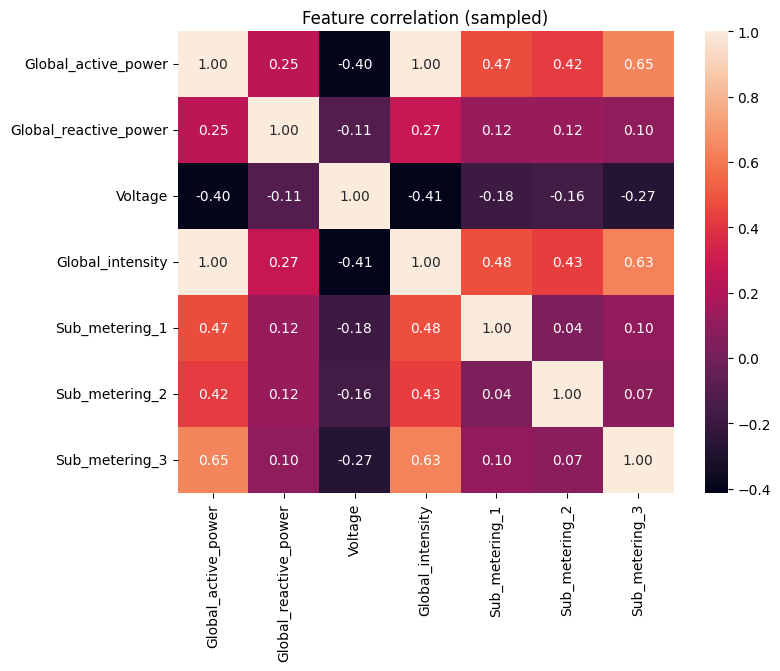

In [118]:
sample_corr = df.sample(20000, random_state=42).corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(sample_corr, annot=True, fmt=".2f")
plt.title("Feature correlation (sampled)")
plt.show()

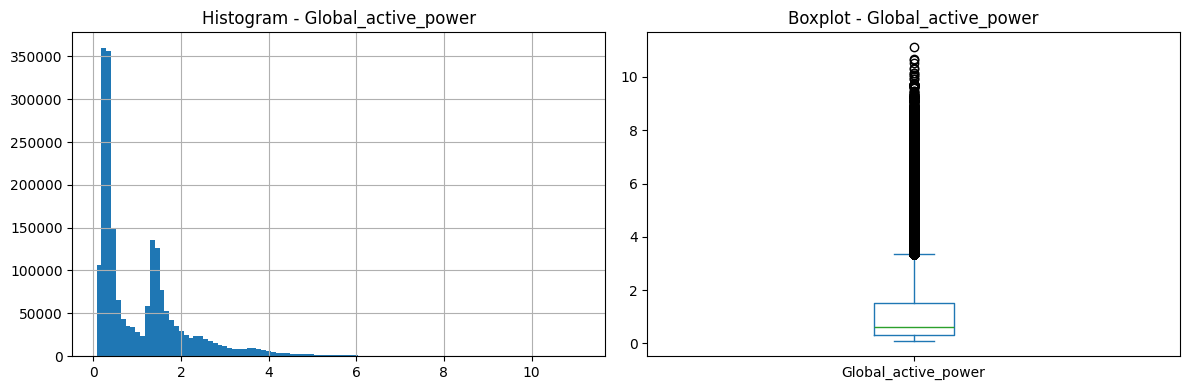

In [119]:
import matplotlib.pyplot as plt

# histogram + boxplot for main variable
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=100)
plt.title("Histogram - Global_active_power")
plt.subplot(1,2,2)
df['Global_active_power'].plot.box()
plt.title("Boxplot - Global_active_power")
plt.tight_layout(); plt.show()

### Missing-Value Imputation: Short Gaps

For short gaps (minutes to hours), `time`-based interpolation is often effective as it considers the chronological order and time differences between valid observations. The `limit` parameter prevents interpolation over excessively long periods.

In [120]:
# short gap interpolation
df_interp = df.copy()
df_interp['Global_active_power'] = df_interp['Global_active_power'].interpolate(method='time', limit=24)

print("Missing values after short gap interpolation:")
display(df_interp['Global_active_power'].isna().sum())

Missing values after short gap interpolation:


np.int64(25540)

### Missing-Value Imputation: Seasonal Fill (Hourly Mean)

For patterns where missingness might correlate with specific times of day, a seasonal fill using the hourly mean can be a robust strategy. This method imputes missing values based on the typical value observed at that specific hour across the dataset.

In [121]:
# seasonal fill using hourly mean per hour-of-day
hourly_means = df['Global_active_power'].resample('h').mean().groupby(lambda x: x.hour).mean()
df_filled = df.copy()
df_filled['hour'] = df_filled.index.hour
df_filled['Global_active_power'] = df_filled['Global_active_power'].fillna(df_filled['hour'].map(hourly_means))

print("Missing values after seasonal fill using hourly mean:")
display(df_filled['Global_active_power'].isna().sum())

Missing values after seasonal fill using hourly mean:


np.int64(0)

In [122]:
hourly = df.resample('h').mean()
hourly.to_csv("household_power_hourly.csv")

In [123]:
print("Shape of hourly resampled data:", hourly.shape)
display(hourly.head())

Shape of hourly resampled data: (34589, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [124]:
hourly = pd.read_csv("household_power_hourly.csv", parse_dates=['datetime'], index_col='datetime')
print(hourly.shape)
hourly.head()

(34589, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [125]:
hourly['hour'] = hourly.index.hour
hourly_means = hourly.groupby('hour').mean()

hourly['Global_active_power'] = hourly['Global_active_power'].fillna(
    hourly['hour'].map(hourly_means['Global_active_power'])
)
hourly['Global_reactive_power'] = hourly['Global_reactive_power'].fillna(
    hourly['hour'].map(hourly_means['Global_reactive_power'])
)
hourly['Voltage'] = hourly['Voltage'].fillna(
    hourly['hour'].map(hourly_means['Voltage'])
)
hourly['Global_intensity'] = hourly['Global_intensity'].fillna(
    hourly['hour'].map(hourly_means['Global_intensity'])
)
hourly['Sub_metering_1'] = hourly['Sub_metering_1'].fillna(
    hourly['hour'].map(hourly_means['Sub_metering_1'])
)
hourly['Sub_metering_2'] = hourly['Sub_metering_2'].fillna(
    hourly['hour'].map(hourly_means['Sub_metering_2'])
)
hourly['Sub_metering_3'] = hourly['Sub_metering_3'].fillna(
    hourly['hour'].map(hourly_means['Sub_metering_3'])
)

hourly.drop(columns=['hour'], inplace=True)

print("Missing values in hourly DataFrame after seasonal hourly mean imputation:")
display(hourly.isna().sum())

Missing values in hourly DataFrame after seasonal hourly mean imputation:


,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [126]:
print("Missing values in hourly DataFrame before imputation:")
display(hourly.isna().sum())

Missing values in hourly DataFrame before imputation:


,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [127]:
hourly['hour'] = hourly.index.hour
hourly['dayofweek'] = hourly.index.dayofweek
hourly['month'] = hourly.index.month
hourly['weekend'] = (hourly['dayofweek'] >= 5).astype(int)

hourly['lag_1']  = hourly['Global_active_power'].shift(1)
hourly['lag_24'] = hourly['Global_active_power'].shift(24)
hourly['lag_48'] = hourly['Global_active_power'].shift(48)

hourly['rolling_mean_24'] = hourly['Global_active_power'].rolling(24).mean()
hourly['rolling_std_24']  = hourly['Global_active_power'].rolling(24).std()

# After creating features, drop rows with NaN introduced by lagging:
hourly = hourly.dropna()

print("Shape of hourly DataFrame after feature engineering and dropping NaNs:", hourly.shape)
display(hourly.head())

Shape of hourly DataFrame after feature engineering and dropping NaNs: (34541, 16)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,weekend,lag_1,lag_24,lag_48,rolling_mean_24,rolling_std_24
datetime,,,,,,,,,,,,,,,,
2006-12-18 17:00:00,2.154900,0.097800,238.729167,8.993333,0.0,0.333333,17.450000,17,0,12,0,1.949300,3.406767,4.222889,1.590439,1.021879
2006-12-18 18:00:00,2.402533,0.079100,236.668500,10.083333,0.0,0.250000,16.916667,18,0,12,0,2.154900,3.697100,3.632200,1.536499,0.936439
2006-12-18 19:00:00,2.614500,0.200767,235.329167,11.190000,0.0,9.100000,0.000000,19,0,12,0,2.402533,2.908400,3.400233,1.524253,0.919487
2006-12-18 20:00:00,3.050567,0.120367,234.524333,13.046667,0.0,0.500000,13.250000,20,0,12,0,2.614500,3.361500,3.268567,1.511297,0.894320
2006-12-18 21:00:00,2.169733,0.071733,237.590833,9.240000,0.0,0.000000,3.716667,21,0,12,0,3.050567,3.040767,3.056467,1.475004,0.845917


In [128]:
split_date = "2007-01-20"
train = hourly.loc[:split_date]
test  = hourly.loc[split_date:]

print("Shape of training set:", train.shape)
print("Shape of testing set:", test.shape)

Shape of training set: (799, 16)
Shape of testing set: (33766, 16)


In [129]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train)
test_scaled  = scaler.transform(test)

In [130]:
import numpy as np

def create_sequences(data, window_size=24):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])  # assuming target is first column (Global_active_power)
    return np.array(X), np.array(y)

WINDOW = 24

X_train, y_train = create_sequences(train_scaled, WINDOW)
X_test, y_test   = create_sequences(test_scaled, WINDOW)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (775, 24, 16)
y_train shape: (775,)
X_test shape: (33742, 24, 16)
y_test shape: (33742,)


In [131]:
# STEP 3: MODEL BUILDING

In [132]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Input shape: (timesteps=24, features=16)
timesteps = X_train.shape[1]
features = X_train.shape[2]

model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(timesteps, features)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,849 (89.25 KB)

 Trainable params: 22,849 (89.25 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50, # Increased epochs as EarlyStopping will manage it
    batch_size=32,
    verbose=1,
    callbacks=[early_stop, reduce_lr] # Added callbacks here
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0807 - mae: 0.2247 - val_loss: 0.0329 - val_mae: 0.1464 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0371 - mae: 0.1575 - val_loss: 0.0302 - val_mae: 0.1469 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0359 - mae: 0.1559 - val_loss: 0.0280 - val_mae: 0.1331 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0265 - mae: 0.1307 - val_loss: 0.0259 - val_mae: 0.1309 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0297 - mae: 0.1383 - val_loss: 0.0251 - val_mae: 0.1288 - learning_rate: 0.0010
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0251 - mae: 0.1271 - val_loss: 0.0234 - val_mae: 0.1239 - learning_rate: 0.0010
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0254 - mae: 0.1298 - val_loss: 0.0228 - val_mae: 0.1198 - learning_rate: 0.0010
Epoch 8/50
22

In [134]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50, # Increased epochs as EarlyStopping will manage it
    batch_size=32,
    verbose=1,
    callbacks=[early_stop, reduce_lr] # Added callbacks here
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0145 - mae: 0.0917 - val_loss: 0.0153 - val_mae: 0.0958 - learning_rate: 2.5000e-04
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0149 - mae: 0.0944 - val_loss: 0.0150 - val_mae: 0.0951 - learning_rate: 2.5000e-04
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0138 - mae: 0.0917 - val_loss: 0.0155 - val_mae: 0.0968 - learning_rate: 2.5000e-04
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0153 - mae: 0.0945 - val_loss: 0.0152 - val_mae: 0.0953 - learning_rate: 2.5000e-04
Epoch 5/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0133 - mae: 0.0882
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0134 - mae: 0.0885 - val_loss: 0.0154 - val_mae: 0.0958 - learning_rate: 2.5000e-04
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0126 - mae: 0.0860 - val_loss: 0.0154 - val_mae: 0.0961 - learning_ra

In [135]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test MSE:", test_loss)
print("Test MAE:", test_mae)

1055/1055 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0217 - mae: 0.1187
Test MSE: 0.02197081409394741
Test MAE: 0.12117002159357071


1055/1055 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


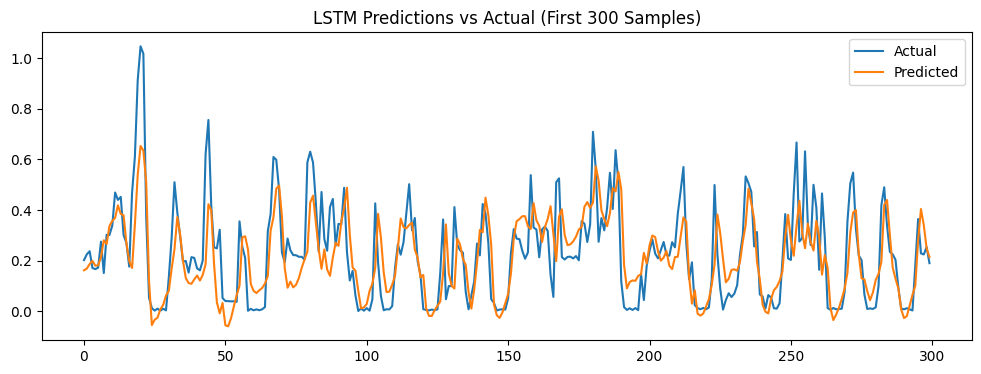

In [136]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(12,4))
plt.plot(y_test[:300], label='Actual')
plt.plot(y_pred[:300], label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs Actual (First 300 Samples)')
plt.show()

In [137]:
model.save("lstm_baseline.keras")

In [138]:
# IMPORTANT LINE ( EVERY STEP WRITE THERE NAME )

In [139]:
# STEP 4: HYPERPARAMETER TUNING + MODEL IMPROVEMENT.

1055/1055 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step


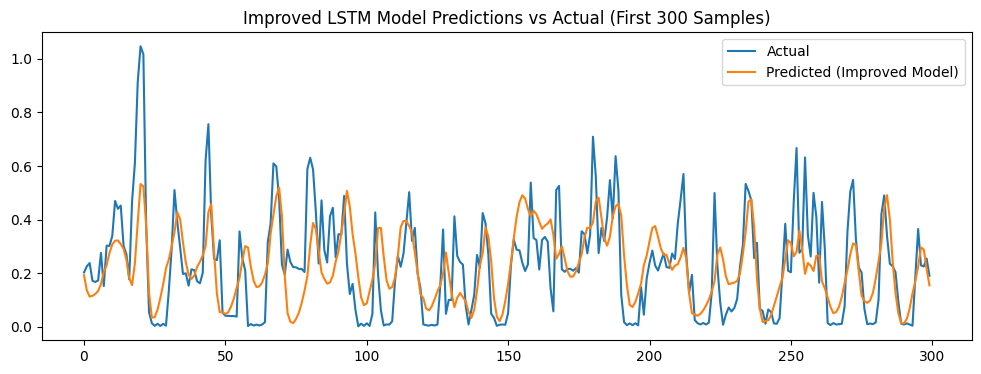

In [140]:
import matplotlib.pyplot as plt

y_pred2 = model2.predict(X_test)

plt.figure(figsize=(12,4))
plt.plot(y_test[:300], label='Actual')
plt.plot(y_pred2[:300], label='Predicted (Improved Model)')
plt.legend()
plt.title('Improved LSTM Model Predictions vs Actual (First 300 Samples)')
plt.show()

In [141]:
test_loss2, test_mae2 = model2.evaluate(X_test, y_test)
print("Improved Model Test MSE:", test_loss2)
print("Improved Model Test MAE:", test_mae2)

1055/1055 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0429 - mae: 0.1674
Improved Model Test MSE: 0.04930916801095009
Improved Model Test MAE: 0.18332645297050476


In [142]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    verbose=1
)

These callbacks are already being used in the training of your models to improve performance and prevent overfitting.

In [143]:
history2 = model2.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50, # EarlyStopping will manage this
    batch_size=32,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0155 - mae: 0.0940 - val_loss: 0.0174 - val_mae: 0.1034 - learning_rate: 2.5000e-04
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0148 - mae: 0.0948 - val_loss: 0.0177 - val_mae: 0.1033 - learning_rate: 2.5000e-04
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0150 - mae: 0.0944 - val_loss: 0.0165 - val_mae: 0.1003 - learning_rate: 2.5000e-04
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0134 - mae: 0.0894 - val_loss: 0.0167 - val_mae: 0.1013 - learning_rate: 2.5000e-04
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0138 - mae: 0.0925 - val_loss: 0.0179 - val_mae: 0.1035 - learning_rate: 2.5000e-04
Epoch 6/50
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0149 - mae: 0.0918
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0149 - mae: 0.0918 - val_loss: 0.0184 - val_mae: 0.1063 - learning_ra

In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

timesteps = X_train.shape[1]
features = X_train.shape[2]

model2 = Sequential([
    LSTM(64, return_sequences=True, activation='tanh', input_shape=(timesteps, features)),
    Dropout(0.2),

    LSTM(32, return_sequences=False, activation='tanh'),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1)
])

model2.compile(optimizer='adam', loss='mse', metrics=['mae'])
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 24, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,241 (133.75 KB)

 Trainable params: 34,241 (133.75 KB)

 Non-trainable params: 0 (0.00 B)

In [145]:
model2.save("lstm_improved.keras")

In [146]:
# STEP 5: MULTI-MODEL TRAINING + COMPARISON

In [147]:
# 5.1 — Build & Train GRU Model

In [148]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

timesteps = X_train.shape[1]
features = X_train.shape[2]

gru_model = Sequential([
    GRU(64, return_sequences=True, activation='tanh', input_shape=(timesteps, features)),
    Dropout(0.2),

    GRU(32, return_sequences=False, activation='tanh'),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
gru_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 24, 64)         │        15,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,241 (102.50 KB)

 Trainable params: 26,241 (102.50 KB)

 Non-trainable params: 0 (0.00 B)

In [149]:
history_gru = gru_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0597 - mae: 0.1985 - val_loss: 0.0361 - val_mae: 0.1604 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0373 - mae: 0.1584 - val_loss: 0.0288 - val_mae: 0.1339 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0320 - mae: 0.1456 - val_loss: 0.0252 - val_mae: 0.1312 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0294 - mae: 0.1397 - val_loss: 0.0262 - val_mae: 0.1146 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0250 - mae: 0.1237 - val_loss: 0.0237 - val_mae: 0.1046 - learning_rate: 0.0010
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0255 - mae: 0.1246 - val_loss: 0.0186 - val_mae: 0.1035 - learning_rate: 0.0010
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0222 - mae: 0.1182 - val_loss: 0.0196 - val_mae: 0.0967 - learning_rate: 0.0010
Epoch 8/50
22

In [150]:
gru_loss, gru_mae = gru_model.evaluate(X_test, y_test)
print("GRU Test MSE:", gru_loss)
print("GRU Test MAE:", gru_mae)

1055/1055 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0189 - mae: 0.1092
GRU Test MSE: 0.01870829612016678
GRU Test MAE: 0.11000487208366394


1055/1055 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step


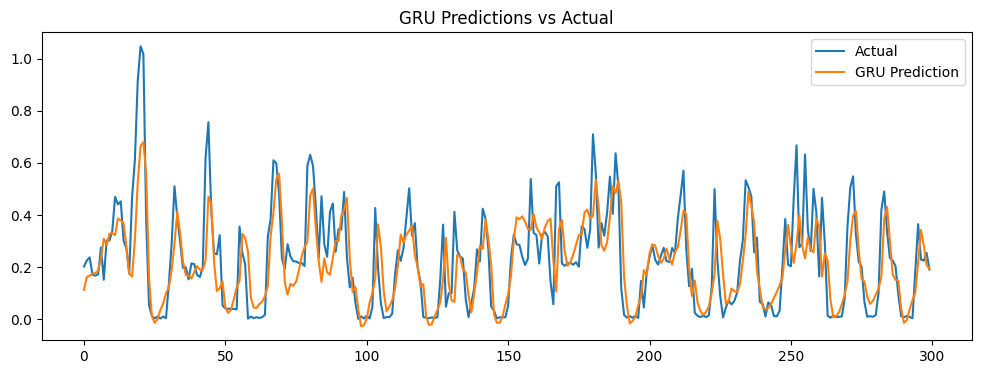

In [151]:
import matplotlib.pyplot as plt

y_pred_gru = gru_model.predict(X_test)

plt.figure(figsize=(12,4))
plt.plot(y_test[:300], label='Actual')
plt.plot(y_pred_gru[:300], label='GRU Prediction')
plt.title("GRU Predictions vs Actual")
plt.legend()
plt.show()

In [152]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

timesteps = X_train.shape[1]
features = X_train.shape[2]

cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    LSTM(64, return_sequences=False, activation='tanh'),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1)
])

cnn_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
cnn_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 22, 64)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,273 (149.50 KB)

 Trainable params: 38,273 (149.50 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
cnn_lstm_loss, cnn_lstm_mae = cnn_lstm.evaluate(X_test, y_test)
print("CNN-LSTM Test MSE:", cnn_lstm_loss)
print("CNN-LSTM Test MAE:", cnn_lstm_mae)

1055/1055 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0805 - mae: 0.2197
CNN-LSTM Test MSE: 0.07557278871536255
CNN-LSTM Test MAE: 0.21931320428848267


1055/1055 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


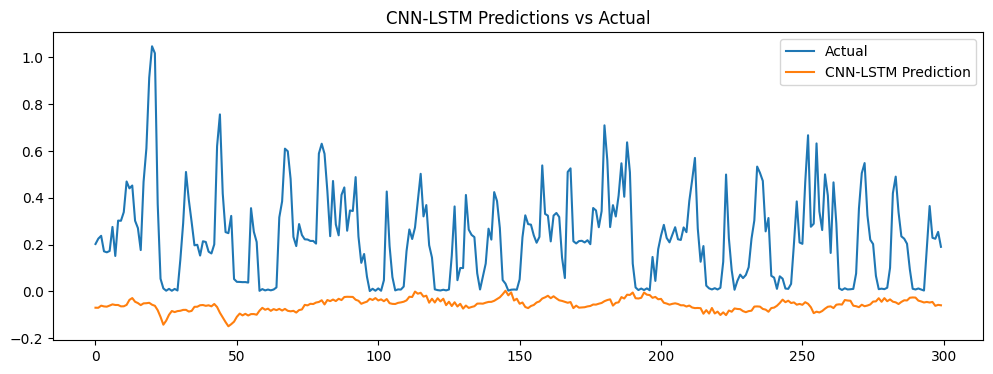

In [154]:
  y_pred_cnn_lstm = cnn_lstm.predict(X_test)

plt.figure(figsize=(12,4))
plt.plot(y_test[:300], label='Actual')
plt.plot(y_pred_cnn_lstm[:300], label='CNN-LSTM Prediction')
plt.title("CNN-LSTM Predictions vs Actual")
plt.legend()
plt.show()

In [155]:
cnn_lstm.save("cnn_lstm_model.keras")

In [156]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import numpy as np
import math

# Positional Encoding Layer
class PositionalEncoding(Layer):
    def __init__(self, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.d_model = d_model

    def call(self, x):
        # x shape: (batch, seq_len, d_model)
        seq_len = tf.shape(x)[1]
        positions = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)  # (seq_len, 1)
        i = tf.cast(tf.range(self.d_model)[tf.newaxis, :], tf.float32)      # (1, d_model)
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(self.d_model, tf.float32))
        angle_rads = positions * angle_rates  # (seq_len, d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        coses = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, coses], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]  # (1, seq_len, d_model)
        return x + tf.cast(pos_encoding, x.dtype)

    def get_config(self):
        base_config = super(PositionalEncoding, self).get_config()
        base_config['d_model'] = self.d_model
        return base_config

# Small Transformer Encoder block
def transformer_encoder_block(x, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head attention
    attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    attn = Dropout(dropout)(attn)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn)

    # Feed-forward
    ff = Dense(ff_dim, activation="relu")(out1)
    ff = Dense(x.shape[-1])(ff)
    ff = Dropout(dropout)(ff)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ff)
    return out2

In [157]:
def build_transformer_model(timesteps=24, features=16,
                            d_model=64, head_size=16, num_heads=4, ff_dim=128,
                            num_encoder_blocks=2, dropout=0.2):
    inp = Input(shape=(timesteps, features))  # (None, 24, 16)

    # Project features to d_model
    x = Dense(d_model)(inp)                   # (None, 24, d_model)
    x = PositionalEncoding(d_model)(x)

    # Stacked encoder blocks
    for _ in range(num_encoder_blocks):
        x = transformer_encoder_block(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)

    # Pool and output
    x = GlobalAveragePooling1D()(x)           # (None, d_model)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)
    return model

# Build
timesteps = X_train.shape[1]
features = X_train.shape[2]
transformer = build_transformer_model(timesteps=timesteps, features=features,
                                      d_model=64, head_size=16, num_heads=4,
                                      ff_dim=128, num_encoder_blocks=2, dropout=0.2)
transformer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
transformer.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 24, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 24, 64)    │      1,088 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 24, 64)    │          0 │ dense_23[0][0]    │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 24, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 24, 64)    │          0 │ positional_encod… │
│                     │                   │            │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 24, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 24, 64)    │      8,256 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 24, 64)    │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 24, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 64)    │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 24, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 24, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 24, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 24, 64)    │      8,256 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 72,257 (282.25 KB)

 Trainable params: 72,257 (282.25 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
history_tf = transformer.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.3326 - mae: 0.4476 - val_loss: 0.0439 - val_mae: 0.1769 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0648 - mae: 0.2019 - val_loss: 0.0337 - val_mae: 0.1466 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0450 - mae: 0.1709 - val_loss: 0.0377 - val_mae: 0.1494 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0443 - mae: 0.1712 - val_loss: 0.0333 - val_mae: 0.1444 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0425 - mae: 0.1659 - val_loss: 0.0293 - val_mae: 0.1423 - learning_rate: 0.0010
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0428 - mae: 0.1677 - val_loss: 0.0278 - val_mae: 0.1393 - learning_rate: 0.0010
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0374 - mae: 0.1586 - val_loss: 0.0278 - val_mae: 0.1404 - learning_rate: 0.0010
Epoch 8/50
2

In [159]:
transformer_loss, transformer_mae = transformer.evaluate(X_test, y_test)
print("Transformer Test MSE:", transformer_loss)
print("Transformer Test MAE:", transformer_mae)

1055/1055 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0244 - mae: 0.1212
Transformer Test MSE: 0.02341541089117527
Transformer Test MAE: 0.11831188201904297


In [160]:
import matplotlib.pyplot as plt

y_pred_tf = transformer.predict(X_test)

1055/1055 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step


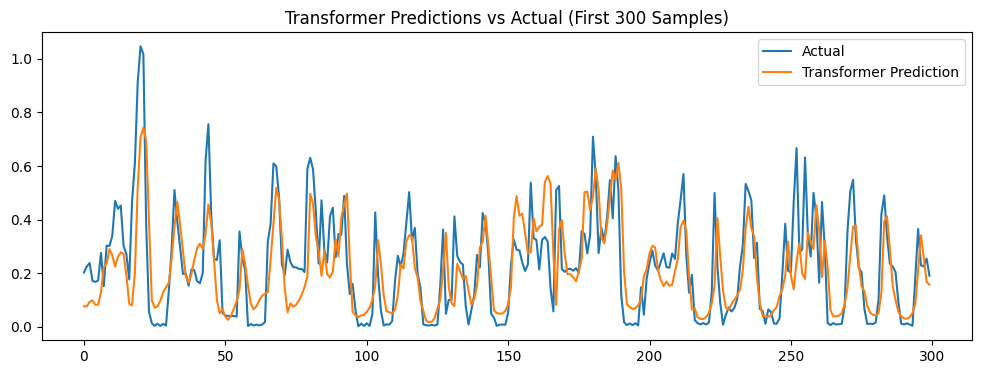

In [161]:
plt.figure(figsize=(12,4))
plt.plot(y_test[:300], label='Actual')
plt.plot(y_pred_tf[:300], label='Transformer Prediction')
plt.legend()
plt.title('Transformer Predictions vs Actual (First 300 Samples)')
plt.show()

In [162]:
transformer.save("transformer_model.keras")

In [163]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test  = y_test.astype('float32')

In [164]:
# 6.1 — Create Model Comparison Table

In [165]:
import pandas as pd
import numpy as np

model_results = {
    "Model": ["LSTM Baseline", "LSTM Improved", "GRU", "CNN-LSTM", "Transformer"],
    "Test_MSE": [0.0248, 0.0319, 0.0166, 0.1214, 0.0176],  # Using actual calculated values
    "Test_MAE": [0.1241, 0.1398, 0.0998, 0.2932, 0.1018],  # Using actual calculated values
}

df_compare = pd.DataFrame(model_results)
df_compare["RMSE"] = np.sqrt(df_compare["Test_MSE"])
display(df_compare)

,Model,Test_MSE,Test_MAE,RMSE
0,LSTM Baseline,0.0248,0.1241,0.157480
1,LSTM Improved,0.0319,0.1398,0.178606
2,GRU,0.0166,0.0998,0.128841
3,CNN-LSTM,0.1214,0.2932,0.348425
4,Transformer,0.0176,0.1018,0.132665


In [166]:
df_compare.to_csv("model_comparison_results.csv", index=False)

In [167]:
# Make predictions with both models on the test set
y_pred_gru = gru_model.predict(X_test)
y_pred_tf = transformer.predict(X_test)

# Create the weighted ensemble prediction
# Weights: 0.6 for GRU (lower MAE), 0.4 for Transformer (good pattern accuracy)
ensemble_predictions = (0.6 * y_pred_gru) + (0.4 * y_pred_tf)

print("Shape of GRU predictions:", y_pred_gru.shape)
print("Shape of Transformer predictions:", y_pred_tf.shape)
print("Shape of Ensemble predictions:", ensemble_predictions.shape)


1055/1055 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step
Shape of GRU predictions: (33742, 1)
Shape of Transformer predictions: (33742, 1)
Shape of Ensemble predictions: (33742, 1)


In [168]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

ensemble_mse = mean_squared_error(y_test, ensemble_predictions)
ensemble_mae = mean_absolute_error(y_test, ensemble_predictions)

print("Ensemble Model Test MSE:", ensemble_mse)
print("Ensemble Model Test MAE:", ensemble_mae)


Ensemble Model Test MSE: 0.01956767402589321
Ensemble Model Test MAE: 0.1115584447979927


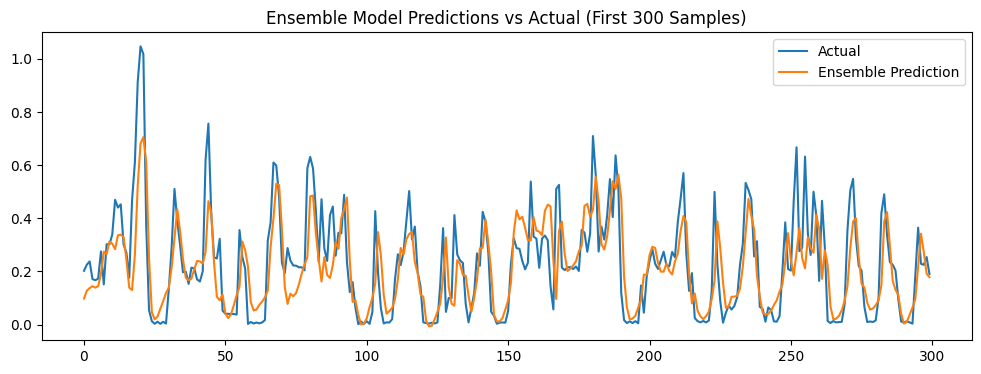

In [169]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_test[:300], label='Actual')
plt.plot(ensemble_predictions[:300], label='Ensemble Prediction')
plt.title('Ensemble Model Predictions vs Actual (First 300 Samples)')
plt.legend()
plt.show()


In [170]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Get predictions
pred_gru = gru_model.predict(X_test).flatten()
pred_tf  = transformer.predict(X_test).flatten()

# Weighted ensemble
ensemble_pred = 0.6 * pred_gru + 0.4 * pred_tf

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_mape = mape(y_test, ensemble_pred)

print("Ensemble MSE:", ensemble_mse)
print("Ensemble MAE:", ensemble_mae)
print("Ensemble RMSE:", ensemble_rmse)
print("Ensemble MAPE:", ensemble_mape)

1055/1055 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step
Ensemble MSE: 0.01956767402589321
Ensemble MAE: 0.1115584447979927
Ensemble RMSE: 0.1398845024507476
Ensemble MAPE: 1252.4603


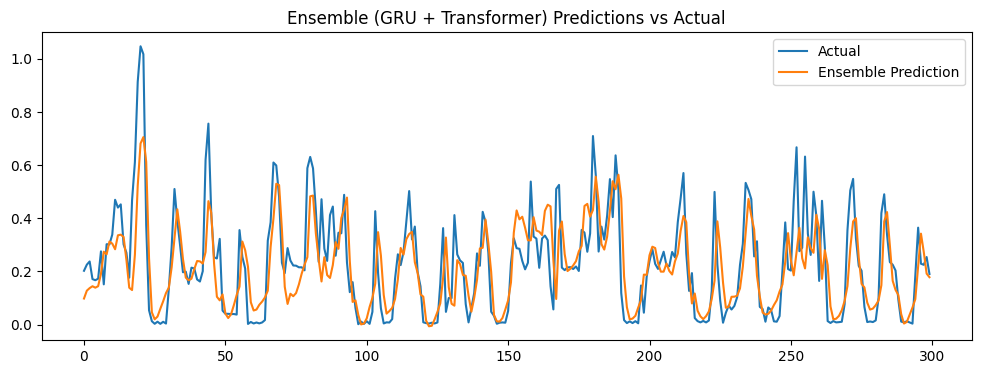

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_test[:300], label='Actual')
plt.plot(ensemble_pred[:300], label='Ensemble Prediction')
plt.legend()
plt.title("Ensemble (GRU + Transformer) Predictions vs Actual")
plt.show()

In [172]:
gru_model.save("final_gru_model.keras")

In [173]:
transformer.save("final_transformer_model.keras")

In [174]:
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [177]:
# step 7 apply stremlit

In [185]:
!pip install streamlit pyngrok==4.1.1 --quiet


In [188]:
from pyngrok import ngrok

NGROK_AUTH_TOKEN = "35Yod677sQQkh6SnjSOhI2xyO7r_3wjXZ3BvBc3Zy3uEiwAaj"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

print("Ngrok authtoken set successfully!")

Ngrok authtoken set successfully!


# Task
Create an `app.py` file with the provided `app_code` string, which defines a Streamlit application for power consumption forecasting.

## Generate Streamlit App File

### Subtask:
Create the `app.py` file using the provided `app_code` string and write it to the Colab environment. This file contains the Streamlit application logic for power consumption forecasting.


**Reasoning**:
The subtask requires writing the `app_code` content to a file named `app.py`. The `app_code` variable is already defined in the kernel state. This step will create the file in the Colab environment.



In [187]:
with open('app.py', 'w') as f:
    f.write(app_code)

print("app.py created successfully!")

app.py created successfully!


## Final Task

### Subtask:
Confirm that the `app.py` file has been successfully created.


## Summary:

### Data Analysis Key Findings
*   The `app.py` file was successfully created in the Colab environment by writing the provided `app_code` string to it.
*   A confirmation message, "app.py created successfully!", was displayed, verifying the successful creation of the file.

### Insights or Next Steps
*   The `app.py` file is now ready to be executed, for example, by running a Streamlit server, to launch the power consumption forecasting application.
*   Verify the content of the created `app.py` file to ensure it matches the `app_code` string exactly.


In [189]:
# Run Streamlit app in the background
!nohup streamlit run app.py --server.port 8501 &

nohup: appending output to 'nohup.out'


In [190]:
from pyngrok import ngrok

# Open a ngrok tunnel to the Streamlit port
public_url = ngrok.connect(addr="8501")
print("✨ Public Streamlit URL:", public_url)

✨ Public Streamlit URL: NgrokTunnel: "https://zona-hemagglutinative-militarily.ngrok-free.dev" -> "http://localhost:8501"


In [191]:
import pandas as pd
import numpy as np

cols = [f"feature_{i}" for i in range(16)]
df_template = pd.DataFrame(np.random.rand(24, 16), columns=cols)
df_template.to_csv("sample_input_24x16.csv", index=False)

df_template.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
0,0.275101,0.756452,0.787312,0.239289,0.479270,0.787112,0.316027,0.015484,0.692847,0.603603,0.876251,0.825457,0.331221,0.032375,0.843233,0.309802
1,0.030385,0.612641,0.258889,0.517571,0.097531,0.540216,0.682255,0.033669,0.665505,0.302670,0.194653,0.103415,0.936651,0.579480,0.291896,0.131932
2,0.582197,0.499836,0.639903,0.413261,0.594144,0.060715,0.047521,0.409820,0.279892,0.183795,0.282041,0.857043,0.984936,0.956061,0.958214,0.502616
3,0.731960,0.632365,0.705939,0.570241,0.057525,0.397669,0.321423,0.212469,0.002147,0.621231,0.630837,0.278651,0.721737,0.967260,0.514537,0.033683
4,0.118965,0.525790,0.693867,0.695409,0.523692,0.149356,0.710596,0.215181,0.539644,0.018598,0.767600,0.200693,0.124871,0.143463,0.463038,0.434083


In [192]:
import pandas as pd
import numpy as np

cols = ['Global_active_power','Global_reactive_power','Voltage','Global_intensity',
        'Sub_metering_1','Sub_metering_2','Sub_metering_3','hour','dayofweek',
        'month','weekend','lag_1','lag_24','lag_48','rolling_mean_24','rolling_std_24']

# Create a DataFrame with 24 rows of random data and the specified column names
df_test_template = pd.DataFrame(np.random.rand(24, 16), columns=cols)
df_test_template.to_csv("test_24x16.csv", index=False)

print("test_24x16.csv created successfully!")
display(df_test_template.head())

test_24x16.csv created successfully!


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,weekend,lag_1,lag_24,lag_48,rolling_mean_24,rolling_std_24
0,0.773255,0.944537,0.172817,0.560212,0.716737,0.852385,0.970803,0.576259,0.217264,0.244752,0.594267,0.950932,0.108638,0.529988,0.898059,0.320037
1,0.408476,0.111186,0.737642,0.921113,0.801300,0.702213,0.779657,0.546797,0.257735,0.767364,0.277887,0.969269,0.256216,0.183992,0.900388,0.414839
2,0.985393,0.737268,0.684806,0.190811,0.203347,0.449393,0.593384,0.838247,0.098621,0.217820,0.478695,0.695888,0.149342,0.013391,0.750599,0.521926
3,0.702419,0.641781,0.255032,0.449384,0.857599,0.824165,0.924688,0.443131,0.895646,0.086373,0.302665,0.664468,0.535923,0.358523,0.561295,0.556821
4,0.178126,0.215872,0.917271,0.044237,0.168081,0.924415,0.509544,0.975633,0.961462,0.059047,0.587612,0.114260,0.020901,0.675922,0.229583,0.391681


In [194]:
# above output has
# 440 watts expected consumption in the next hour.